In [1]:
from skimage.filters import try_all_threshold
from scipy import ndimage as ndi
from skimage import feature, filters
from skimage.filters import gaussian
from matplotlib import pyplot as plt
import numpy as np
import statistics
import cv2
from PIL import Image

from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu

In [2]:
def denoise(can,ndwi):
    kernel = np.ones((7,7),np.uint8)
    dilation = ndi.binary_dilation(can,kernel,iterations=30)
    both = np.logical_and(ndwi,dilation)
    return both

def acc_metrics(y_pred, y_true):
    SMOOTH = 1e-6
    n_sample = y_true.shape[0]*y_true.shape[1]
    acc = (y_pred == y_true).sum() / n_sample

    TP = np.logical_and(y_pred, y_true).sum()  # true positive
    FP = y_pred.sum() - TP  # false positive
    FN = y_true.sum() - TP  # false negative
    TN = (y_pred == y_true).sum() - TP

    precision = (TP + SMOOTH) / (TP + FP + SMOOTH)
    recall = (TP + SMOOTH) / (TP + FN + SMOOTH)
    f1 = 2.0 / (1.0 / precision + 1.0 / recall)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print('precision: ', precision)
    print('recall: ', recall)
    print('f1: ', f1)
    print('accuracy: ', accuracy)
    
def iou_score(y_pred, y_true):
    SMOOTH = 1e-6
    intersection = np.logical_and(y_pred, y_true)
    union = np.logical_or(y_pred, y_true)
    iou_score = np.sum(intersection + SMOOTH) / np.sum(union + SMOOTH)
    print('iou: ', iou_score)

In [3]:
def threshold(method,image,y_true):
    thresh = method(image)
    binary = image > thresh
    plt.imshow(binary)
    acc_metrics(binary,y_true)
    iou_score(binary,y_true)
    print('\n gaussian')
    gaus = gaussian(binary, sigma=0.25) > 0
    acc_metrics(gaus,y_true)
    iou_score(gaus,y_true)
    return binary, gaus

In [4]:
def visualize_conf(img, gt):
    TP = np.logical_and(img,gt)*1.0
    FP = (img-TP)*1.0
    inv_img = 1-img
    inv_gt = 1-gt
    TN = np.logical_and(inv_img,inv_gt)*1.0
    FN = (inv_img-TN)*1.0
    
    print('FP: ',FP.sum()/gt.size)
    print('FN: ',FN.sum()/gt.size)
    
    gt_FP = (gt+1)+(FP*3)
    TN10 = np.where(gt_FP == 1, 10, gt_FP)
    TP20 = np.where(TN10 == 2, 20, TN10)
    FP30 = np.where(TP20 == 4, 30, TP20)
    gt_FPFN = FP30 - FN
    FN40 = np.where(gt_FPFN == 19, 40, gt_FPFN)
    
    # define color map 
    color_map = {10: np.array([0, 0, 0]), # black TN
                 20: np.array([255, 255, 255]), # white TP
                 30: np.array([0, 255, 0]), # green FP
                 40: np.array([255, 0, 0])} # red FN
    
    # make a 3d numpy array that has a color channel dimension   
    data_3d = np.ndarray(shape=(FN40.shape[0], FN40.shape[1], 3), dtype=int)
    for i in range(0, FN40.shape[0]):
        for j in range(0, FN40.shape[1]):
            data_3d[i][j] = color_map[FN40[i][j]]
        
#     plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(data_3d)
#     return data_3d

In [5]:
def read_tiff(img):
    im = Image.open(img)
    return np.array(im)

In [29]:
p1_frame = read_tiff('florence_test/framework_p1.tif')[1:-1, 1:-1]
p2_frame = read_tiff('florence_test/framework_p2.tif')[1:-1, 1:-1]
p1_hand = np.load('exclude_openwater/florence_label_p1_floodmask.npy')
p2_hand = np.load('exclude_openwater/florence_label_p2_floodmask.npy')
p1_gt = read_tiff('florence_test/handlabel_p1.tif')[1:-1, 1:-1]
p2_gt = read_tiff('florence_test/handlabel_p2.tif')[1:-1, 1:-1]

In [30]:
p1_frame.shape, p1_hand.shape, p1_gt.shape

((1024, 1024), (1024, 1024), (1024, 1024))

In [31]:
acc_metrics(p1_frame,p1_hand)
iou_score(p1_frame,p1_hand)

precision:  0.8166950860337414
recall:  0.9306495204114725
f1:  0.86995648979163
accuracy:  0.9248933792114258
iou:  0.7698440625869223


In [32]:
acc_metrics(p2_frame,p2_hand)
iou_score(p2_frame,p2_hand)

precision:  0.6527014408652291
recall:  0.9234196149847026
f1:  0.7648109401072775
accuracy:  0.8667535781860352
iou:  0.6191864138567914


FP:  0.05638599395751953
FN:  0.018720626831054688


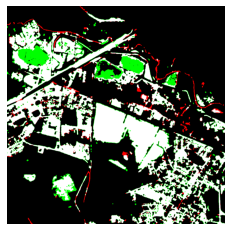

In [33]:
visualize_conf(p1_frame,p1_hand)

FP:  0.1152791976928711
FN:  0.01796722412109375


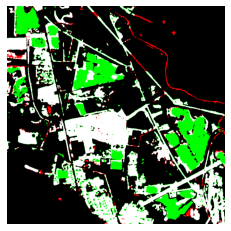

In [36]:
visualize_conf(p2_frame,p2_hand)

(1024, 1024)

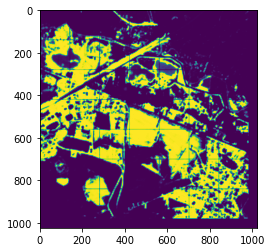

In [8]:
# recon_pred = (np.load('/Volumes/LaCie/deeplearning/data/florence/knn/reconstruct/predict_to_find_hist/predict.npy'))
recon_pred4 = (np.load('./myunet/myunet_reconstruct/predict_to_find_hist/harvey/models_train_harvey_framework_dicebceloss_no_normalize_transform/predict_v4.npy'))
recon_pred14 = (np.load('./myunet/myunet_reconstruct/predict_to_find_hist/harvey/models_train_harvey_framework_dicebceloss_no_normalize_transform/predict_v14.npy'))
# har4 = np.array(Image.open('./harvey_eval_site_v2_floodmask/planet_harvey_southwest_tx_aoi_v2_pixel_watermap_eval_p1_edit_v4.tif'))
# har14 =  np.array(Image.open('./harvey_eval_site_v2_floodmask/planet_harvey_southwest_tx_aoi_v2_pixel_watermap_eval_p2_edit_v14.tif'))
recon_pred = np.load('./myunet/myunet_reconstruct/predict_to_find_hist/models_train_florence_handlabel_p1/predict.npy')
recon_pred2 = np.load('./myunet/myunet_reconstruct/predict_to_find_hist/models_train_florence_handlabel_p2/predict.npy')

# plt.imshow(recon_pred4)
plt.imshow(recon_pred)
recon_pred.shape

(1024, 1024)

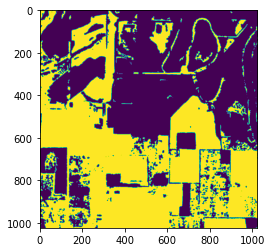

In [9]:
mask4 = np.load('./exclude_openwater/harvey_label_v4_floodmask.npy')
mask14 =  np.load('./exclude_openwater/harvey_label_v14_floodmask.npy')
mask1 = np.load('./exclude_openwater/florence_label_p1_floodmask.npy')
mask2 =  np.load('./exclude_openwater/florence_label_p2_floodmask.npy')
plt.imshow(mask4)
mask4.shape

In [10]:
mask4_crop = np.array(mask4)[0:-44, 0:-44]
mask14_crop = np.array(mask14)[0:-44, 0:-44]
mask1_crop = np.array(mask1)[0:-44, 0:-44]
mask2_crop = np.array(mask2)[0:-44, 0:-44]

In [11]:
recon_pred4_crop = np.array(recon_pred4)[0:-44, 0:-44]
recon_pred14_crop = np.array(recon_pred14)[0:-44, 0:-44]
recon_pred_crop = np.array(recon_pred)[0:-44, 0:-44]
recon_pred2_crop = np.array(recon_pred2)[0:-44, 0:-44]

In [12]:
def knn(img,k=2):
    pixel_values = img.reshape((-1,1))
    pixel_values = np.float32(pixel_values)
#     plt.imshow(pixel_values.reshape(image.shape))
#     pixel_values.shape
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)
    # flatten the labels array
    labels = labels.flatten()
#     plt.imshow(labels.reshape(image.shape))
    labels = np.float64(labels)
#     plt.imshow(labels.reshape(image.shape))
    knn = labels.reshape(img.shape)
    return knn

In [13]:
# floodmask_har1 = np.array(Image.open('./exclude_openwater/har_floodmask_2020_v4.tif'))
# floodmask_har1r = 1 - floodmask_har1
# floodmask_har1r = floodmask_har1r[1:-1, 1:-1]
# tempmask4_crop = np.array(floodmask_har1r)[0:-44, 0:-44]
# newmask4_crop = tempmask4_crop*recon_pred4_crop
# plt.imshow(newmask4_crop)

In [14]:
# floodmask_har2 = np.array(Image.open('./exclude_openwater/har_floodmask_2020_v4.tif'))
# floodmask_har2r = 1 - floodmask_har2
# floodmask_har2r = floodmask_har2r[1:-1, 1:-1]
# tempmask14_crop = np.array(floodmask_har2r)[0:-44, 0:-44]
# newmask14_crop = tempmask14_crop*recon_pred14_crop
# plt.imshow(newmask14_crop)

precision:  0.7307537647450617
recall:  0.9431229715654604
f1:  0.8234664442593193
accuracy:  0.8880414410662224
iou:  0.6999098211778929

 gaussian
precision:  0.6568486291028018
recall:  0.9693313827768004
f1:  0.7830670470329263
accuracy:  0.8513015410245731
iou:  0.6434767711488103
FP:  0.09621095376926281
FN:  0.015747605164514785


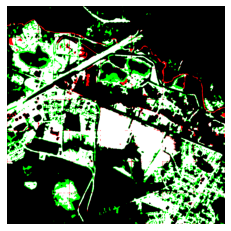

In [16]:
mean1 = threshold(threshold_mean,recon_pred_crop,mask1_crop)
visualize_conf(mean1[0],mask1_crop)

precision:  0.6930224290618155
recall:  0.9512307644537693
f1:  0.8018524854686019
accuracy:  0.8896511870054145
iou:  0.6692445325658405

 gaussian
precision:  0.6167126536140844
recall:  0.9875215699843963
f1:  0.7592620067163621
accuracy:  0.8530102040816326
iou:  0.6119448924175701
FP:  0.09890149937526031
FN:  0.011447313619325281


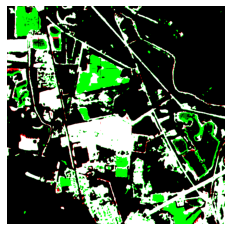

In [17]:
mean2 = threshold(threshold_mean,recon_pred2_crop,mask2_crop)
visualize_conf(mean2[0],mask2_crop)

precision:  0.7645055961470564
recall:  0.926312582971015
f1:  0.8376668316071177
accuracy:  0.9005966264056643
iou:  0.720677828606162


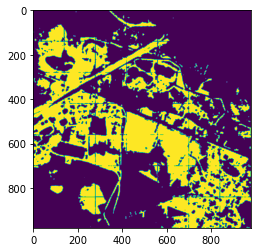

In [19]:
knn_img1 = knn(recon_pred_crop,2)
plt.imshow(knn_img1)
acc_metrics(knn_img1,mask1_crop)
iou_score(knn_img1,mask1_crop)
# print('\n gaussian')
# gaus4 = gaussian(knn_img4, sigma=0.25) > 0
# acc_metrics(gaus4,mask4_crop)
# iou_score(gaus4,mask4_crop)

FP:  0.07900145772594752
FN:  0.02040191586838817


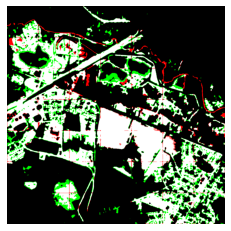

In [20]:
visualize_conf(knn_img1,mask1_crop)

precision:  0.7324397347284731
recall:  0.9259589493812865
f1:  0.8179084242560802
accuracy:  0.9032246980424823
iou:  0.6919172764696745


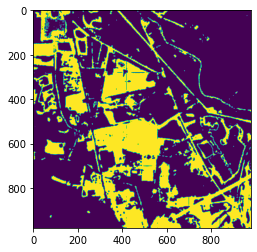

In [22]:
knn_img2 = knn(recon_pred2_crop,2)
plt.imshow(knn_img2)
acc_metrics(knn_img2,mask2_crop)
iou_score(knn_img2,mask2_crop)
# print('\n gaussian')
# gaus14 = gaussian(knn_img14, sigma=0.25) > 0
# acc_metrics(gaus14,mask14_crop)
# iou_score(gaus14,mask14_crop)

FP:  0.07939608496459809
FN:  0.017379216992919617


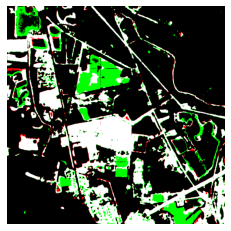

In [23]:
visualize_conf(knn_img2,mask2_crop)

precision:  0.9005756667421132
recall:  0.921135415273387
f1:  0.91073952281369
accuracy:  0.9128644314868805
iou:  0.8361084218739349

 gaussian
precision:  0.8641778937157737
recall:  0.9377791394630646
f1:  0.8994753888022942
accuracy:  0.8988442315701791
iou:  0.8173154355107389
FP:  0.04907642648896293
FN:  0.038059142024156604


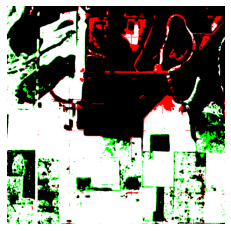

In [82]:
min4 = threshold(threshold_minimum,newmask4_crop,mask4_crop)
visualize_conf(min4[0],mask4_crop)

precision:  0.9176935798757437
recall:  0.8809450861651794
f1:  0.8989439236023576
accuracy:  0.9481695127030404
iou:  0.8164385617284787

 gaussian
precision:  0.866697226166882
recall:  0.9253504482318415
f1:  0.8950639853751754
accuracy:  0.9432215743440233
iou:  0.8100601986073548
FP:  0.020675760099958352
FN:  0.03115472719700125


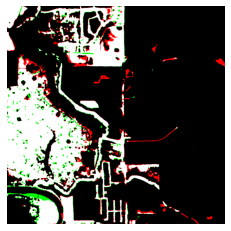

In [84]:
min14 = threshold(threshold_minimum,recon_pred14_crop,mask14_crop)
visualize_conf(min14[0],mask14_crop)

precision:  0.9014951608509519
recall:  0.9206521129375707
f1:  0.9109729346023752
accuracy:  0.9131601416076635
iou:  0.8365019555335335

 gaussian
precision:  0.8650650814067756
recall:  0.9375137546983082
f1:  0.8998335010749952
accuracy:  0.8992732194918784
iou:  0.8179069841829865
FP:  0.04854748021657643
FN:  0.0382923781757601


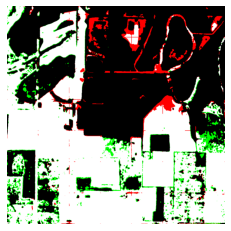

In [85]:
otsu4 = threshold(threshold_otsu,newmask4_crop,mask4_crop)
visualize_conf(otsu4[0],mask4_crop)

precision:  0.9161576053760333
recall:  0.8831852491439904
f1:  0.8993693235578848
accuracy:  0.9482809246147439
iou:  0.8171406216384807

 gaussian
precision:  0.8647851039034516
recall:  0.9269460172451688
f1:  0.8947872796029445
accuracy:  0.9429560599750104
iou:  0.8096070244361834
FP:  0.021150562265722615
FN:  0.030568513119533527


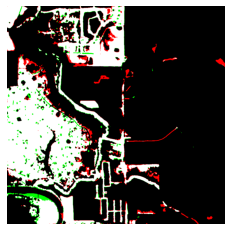

In [89]:
otsu14 = threshold(threshold_otsu,recon_pred14_crop,mask14_crop)
visualize_conf(otsu14[0],mask14_crop)

In [43]:
# florence

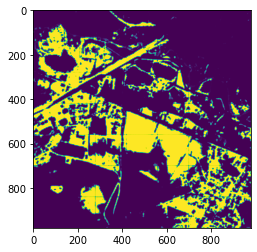

In [90]:
floodmask_flo1 = np.array(Image.open('./exclude_openwater/flo_floodmask_2020_p1.tif'))
floodmask_flo1r = 1 - floodmask_flo1
floodmask_flo1r = floodmask_flo1r[1:-1, 1:-1]
tempmask1_crop = np.array(floodmask_flo1r)[0:-44, 0:-44]
newmask1_crop = tempmask1_crop*recon_pred_crop
plt.imshow(newmask1_crop)

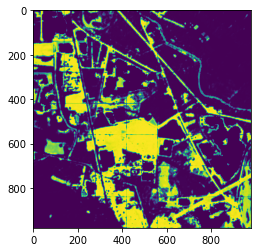

In [91]:
floodmask_flo2 = np.array(Image.open('./exclude_openwater/flo_floodmask_2020_p2.tif'))
floodmask_flo2r = 1 - floodmask_flo2
floodmask_flo2r = floodmask_flo2r[1:-1, 1:-1]
tempmask_crop = np.array(floodmask_flo2r)[0:-44, 0:-44]
newmask2_crop = tempmask_crop*recon_pred2_crop
plt.imshow(newmask2_crop)

precision:  0.8637715750162329
recall:  0.9227624695855214
f1:  0.8922930902192021
accuracy:  0.9383215326947105
iou:  0.8055323673830529

 gaussian
precision:  0.7694007405735075
recall:  0.9572406894141289
f1:  0.8531032356238544
accuracy:  0.9087276134943774
iou:  0.7438368357781487
FP:  0.04029362765514369
FN:  0.021384839650145773


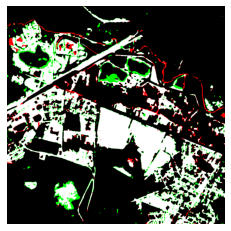

In [103]:
mean1 = threshold(threshold_mean,recon_pred_crop,mask1_crop)
visualize_conf(mean1[0],mask1_crop)

precision:  0.6069526266842915
recall:  0.97255011555757
f1:  0.7474401043228955
accuracy:  0.8457278217409413
iou:  0.5967310843090089

 gaussian
precision:  0.5470872044934801
recall:  0.9944372729329659
f1:  0.7058517923780102
accuracy:  0.8054560599750105
iou:  0.5454191126345384
FP:  0.14782902957101207
FN:  0.0064431486880466475


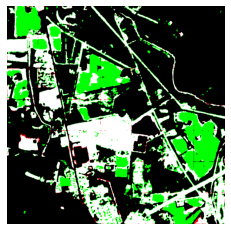

In [109]:
mean2 = threshold(threshold_mean,recon_pred2_crop,mask2_crop)
visualize_conf(mean2[0],mask2_crop)

precision:  0.8679558266174543
recall:  0.9189415848401172
f1:  0.8927213143506151
accuracy:  0.9388504789670971
iou:  0.8062306317324468

 gaussian
precision:  0.7739157454152445
recall:  0.9554129827347327
f1:  0.8551400768130039
accuracy:  0.9103790087463557
iou:  0.7469393220672397
FP:  0.038706788837984174
FN:  0.022442732194918782


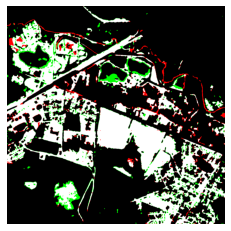

In [110]:
min1 = threshold(threshold_minimum,recon_pred_crop,mask1_crop)
visualize_conf(min1[0],mask1_crop)

precision:  0.6080985075134787
recall:  0.9720177971779496
f1:  0.7481507152169782
accuracy:  0.8463921282798834
iou:  0.5976374661907615

 gaussian
precision:  0.5481929331554071
recall:  0.9942731414325828
f1:  0.7067299809561884
accuracy:  0.8063098708871304
iou:  0.5464685208422929
FP:  0.14703977509371097
FN:  0.006568096626405664


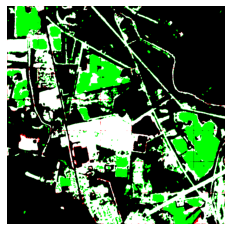

In [111]:
min2 = threshold(threshold_minimum,recon_pred2_crop,mask2_crop)
visualize_conf(min2[0],mask2_crop)

precision:  0.8890248269280816
recall:  0.8963434584275843
f1:  0.8926691423085913
accuracy:  0.9403217409412745
iou:  0.8061455466527904

 gaussian
precision:  0.7989141836358354
recall:  0.9452176888914349
f1:  0.865929727188154
accuracy:  0.9189618908788005
iou:  0.7635598342405749
FP:  0.030978758850478967
FN:  0.028699500208246565


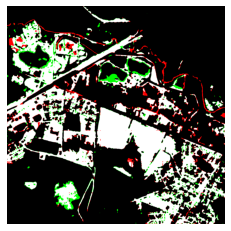

In [112]:
otsu1 = threshold(threshold_otsu,recon_pred_crop,mask1_crop)
visualize_conf(otsu1[0],mask1_crop)

precision:  0.6455223211896106
recall:  0.9586920937414499
f1:  0.7715391906445415
accuracy:  0.8667336526447313
iou:  0.6280546029896593

 gaussian
precision:  0.5796082527271887
recall:  0.9896064836379099
f1:  0.7310460086520807
accuracy:  0.8290837151187005
iou:  0.5761023234306107
FP:  0.12357038733860891
FN:  0.009695960016659726


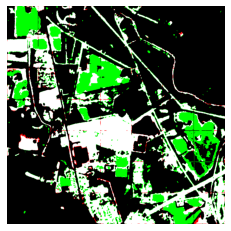

In [113]:
otsu2 = threshold(threshold_otsu,recon_pred2_crop,mask2_crop)
visualize_conf(otsu2[0],mask2_crop)

precision:  0.8877227420936076
recall:  0.8979718473003796
f1:  0.8928178820084625
accuracy:  0.9403061224489796
iou:  0.8063881838145962

 gaussian
precision:  0.7972690707049599
recall:  0.9459547887045247
f1:  0.8652709647685076
accuracy:  0.9184381507705123
iou:  0.7625360085258892


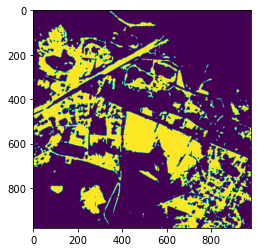

In [114]:
knn_img1 = knn(recon_pred_crop,2)
plt.imshow(knn_img1)
acc_metrics(knn_img1,mask1_crop)
iou_score(knn_img1,mask1_crop)
print('\n gaussian')
gaus1 = gaussian(knn_img1, sigma=0.25) > 0
acc_metrics(gaus1,mask1_crop)
iou_score(gaus1,mask1_crop)

FP:  0.031445231153685964
FN:  0.028248646397334445


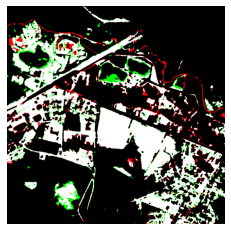

In [115]:
visualize_conf(knn_img1,mask1_crop)

precision:  0.6597645845873487
recall:  0.9537903286624445
f1:  0.7799884277951321
accuracy:  0.8737015826738859
iou:  0.6393297425513906

 gaussian
precision:  0.5914883212911785
recall:  0.9873042066460513
f1:  0.7397791634544773
accuracy:  0.8369658475635152
iou:  0.5870244804011382


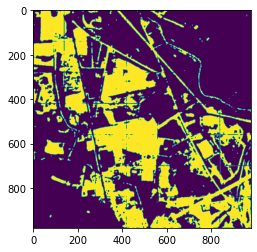

In [116]:
knn_img2 = knn(recon_pred2_crop,2)
plt.imshow(knn_img2)
acc_metrics(knn_img2,mask2_crop)
iou_score(knn_img2,mask2_crop)
print('\n gaussian')
gaus2 = gaussian(knn_img2, sigma=0.25) > 0
acc_metrics(gaus2,mask2_crop)
iou_score(gaus2,mask2_crop)

FP:  0.11545189504373178
FN:  0.01084652228238234


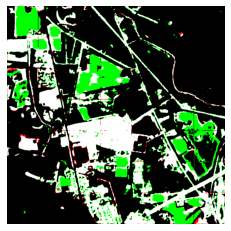

In [117]:
visualize_conf(knn_img2,mask2_crop)